하루 동안 택시 승차 트래픽은 어떻게 변화할까요?

이 질문에 답하기 위해 K-Means Clustering을 사용하여 뉴욕을 위치에 따라 여러 그룹으로 클러스터링하고 각 클러스터로 들어오고 나가는 트래픽을 하루 중 시간의 함수로 분석합니다. 주거 지역은 저녁에 유입되는 트래픽이 더 많은 반면, 상업 지역은 낮에 주로 사람들이 모이고 밤에 유흥이 풍부한 지역은 밤에 더 많은 트래픽을 보일 것으로 예상할 수 있습니다. 

이를 통해 하루 중 시간대별로 각 지역의 목적지가 어디인지 파악할 수 있으므로 체류 시간 예측에 유용할 수 있습니다.

In [8]:
import os
import pandas as pd
import numpy as np

from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from dateutil import parser # datetime 객체로 변환을 위한 dateutil
import io # 데이터 처리
import base64 # base64 인코딩 및 디코딩
from IPython.display import HTML # 노트북안에서 html 표기
from imblearn.under_sampling import RandomUnderSampler # 다수 클래스 상품을 제거하여 소수 클래스 생픔 수를 증가하는 언더샘플링
from subprocess import check_output

# Import necessary libraries

# Importing os module for interacting with the operating system
# Importing pandas library for data manipulation and analysis
# Importing numpy library for numerical operations

# Importing pyplot from matplotlib for creating visualizations
# Importing animation from matplotlib for creating animations
# Importing cm from matplotlib for color maps

# Importing KMeans from sklearn for clustering
# Importing KNeighborsClassifier from sklearn for classification

# Importing parser from dateutil for converting datetime objects
# Importing io for data processing
# Importing base64 for base64 encoding and decoding
# Importing HTML from IPython.display for displaying html in notebooks
# Importing RandomUnderSampler from imblearn for undersampling the majority class to increase the number of minority class samples
# Importing check_output from subprocess for running shell commands

### Read the data

In [9]:
path = 'G:/다른 컴퓨터/My_desktop/project/study/kaggle/data/dynamic new york'
df = pd.read_csv(path+'/train.csv')

In [10]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### Remove rides to and from far away areas

In [11]:
# |The good part of this code is that it filters out the data points in the dataframe `df` that fall outside of the specified longitude and latitude ranges. This is useful for cleaning up the data and removing any outliers that may skew the analysis.
# |
# |The bad part of this code is that it hardcodes the longitude and latitude ranges as variables `xlim` and `ylim`. This may not be ideal if the ranges need to be changed frequently or if the code is reused for different datasets with different ranges. It would be better to make these ranges as parameters that can be passed into the function or script.
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

데이터셋에서 지정한 경도와 위도 범위를 벗어나는 데이터를 제거

### Plot rides

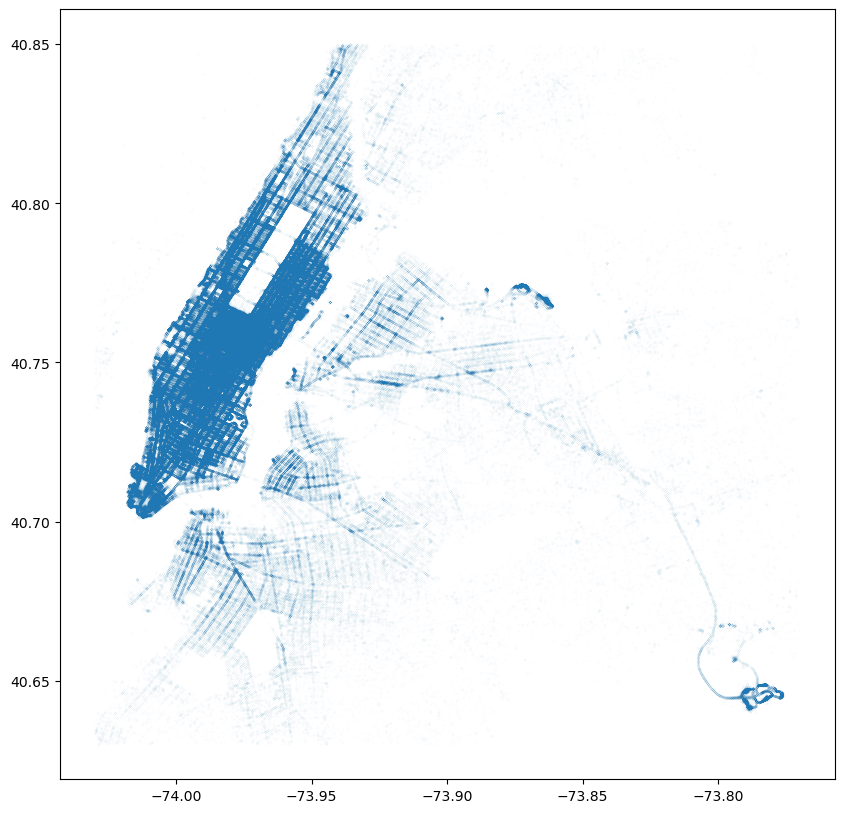

In [ ]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,
         '.',
         alpha = 0.4, # 점의 투명도
         markersize = 0.05 #점의 크기
         )
plt.show()

In [13]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

### Cluster

각 택시의 승차 및 하차 지점을 기준으로 뉴욕시를 클러스터링해 보겠습니다.

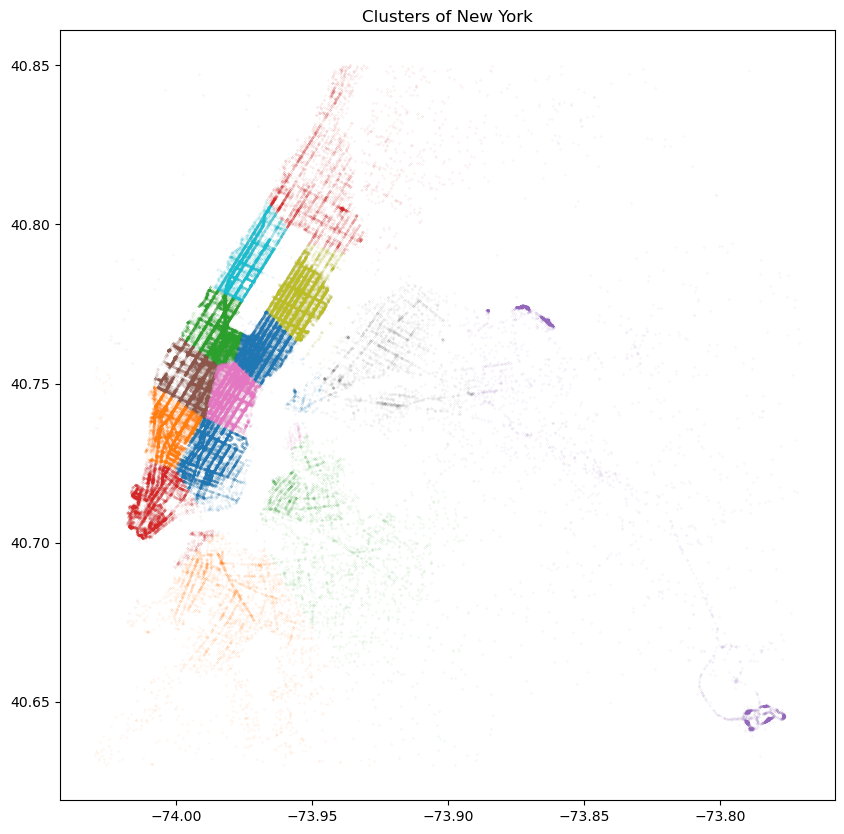

In [14]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],
             loc_df.latitude[loc_df.label == label],
             '.', 
             alpha = 0.3,
             markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

보시다시피, 클러스터링으로 인해 뉴욕이 여러 지역으로 나뉘는 방식과 다소 유사한 파티션이 생성됩니다. 센트럴 파크의 어퍼 이스트와 웨스트사이드는 각각 회색과 분홍색으로 표시됩니다. 웨스트 미드타운은 파란색, 첼시와 웨스트 빌리지는 갈색, 다운타운 지역은 파란색, 이스트 빌리지와 소호는 보라색으로 표시됩니다.

JFK 공항과 라라과디아 공항에는 자체 클러스터가 있으며 퀸즈와 할렘도 마찬가지입니다. 브루클린은 2개의 클러스터로 나뉘며, 브롱크스는 할렘과 분리하기에는 너무 적은 수의 승차권이 있습니다. 
 
클러스터 중심을 그려 보겠습니다:

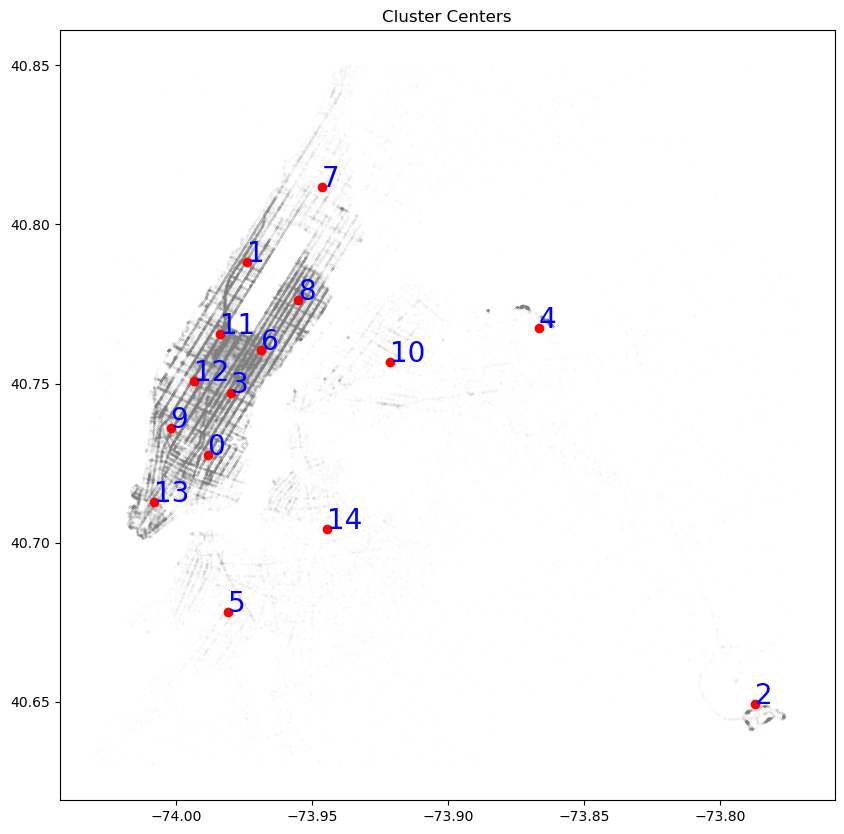

In [15]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [16]:
# df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
# df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
# df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

df['pickup_cluster'] = kmeans.predict(df[['longitude','latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['longitude','latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )


c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
c:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [17]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

In [18]:
loc_df = loc_df.sample(5000)

## Taxi rides from one cluster to another

And the following animation, every arrow represents rides from one cluster to another. The width of the arrow is proportional to the relative amount of trips in the relevant hour.

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\user\AppData\Local\Temp\ipykernel_17364\2758010503.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10));



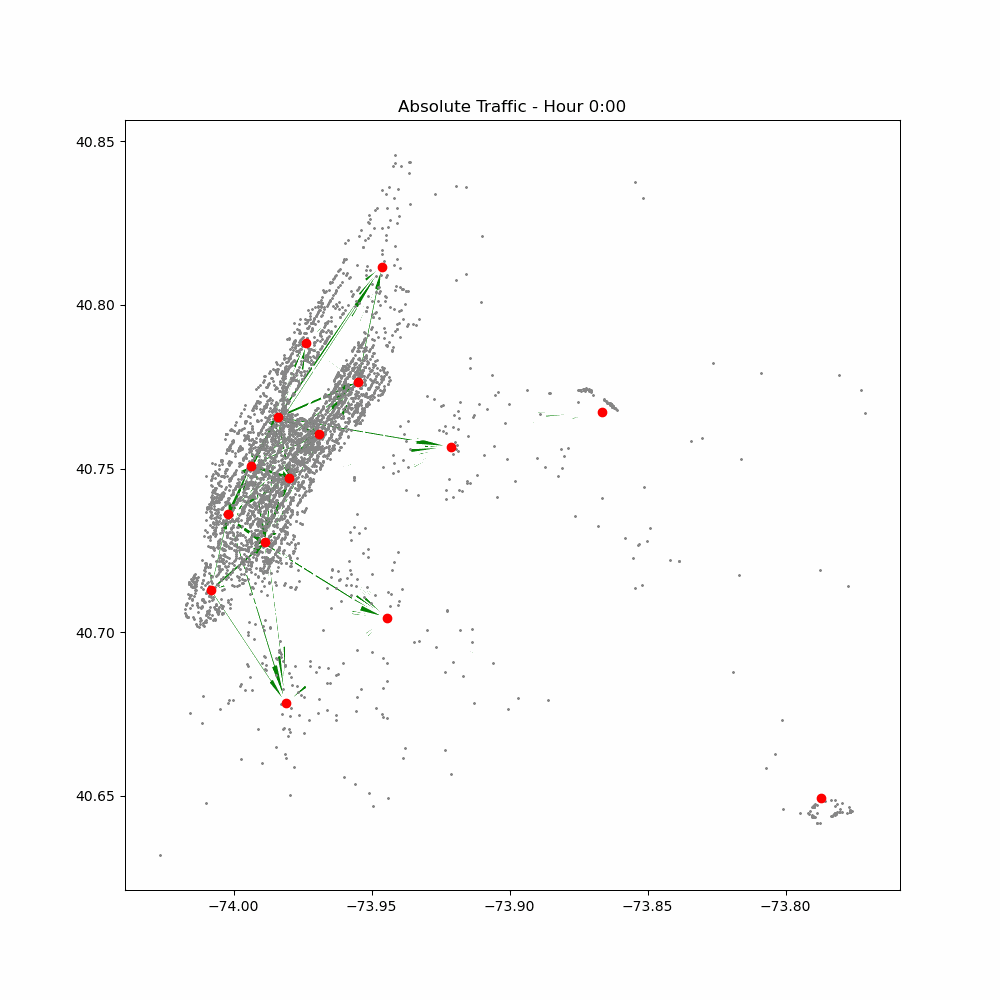

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [19]:
# fig, ax = plt.subplots(1, 1, figsize = (10,10))

# def animate(hour):
#     ax.clear()
#     ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
#     plt.figure(figsize = (10,10));
#     for label in loc_df.label.unique():
#         ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
#         ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


#     for label in clusters.label:
#         for dest_label in clusters.label:
#             num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
#             dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
#             dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
#             pct = np.true_divide(num_of_rides,len(df))
#             arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
#             ax.add_patch(arr)
#             arr.set_facecolor('g')


# ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
# plt.close()
# ani.save('animation.gif', writer='imagemagick', fps=2)
# filename = 'animation.gif'
# video = io.open(filename, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
    
    plt.close()  # 그림 닫기


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\user\AppData\Local\Temp\ipykernel_17364\2082614442.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10))



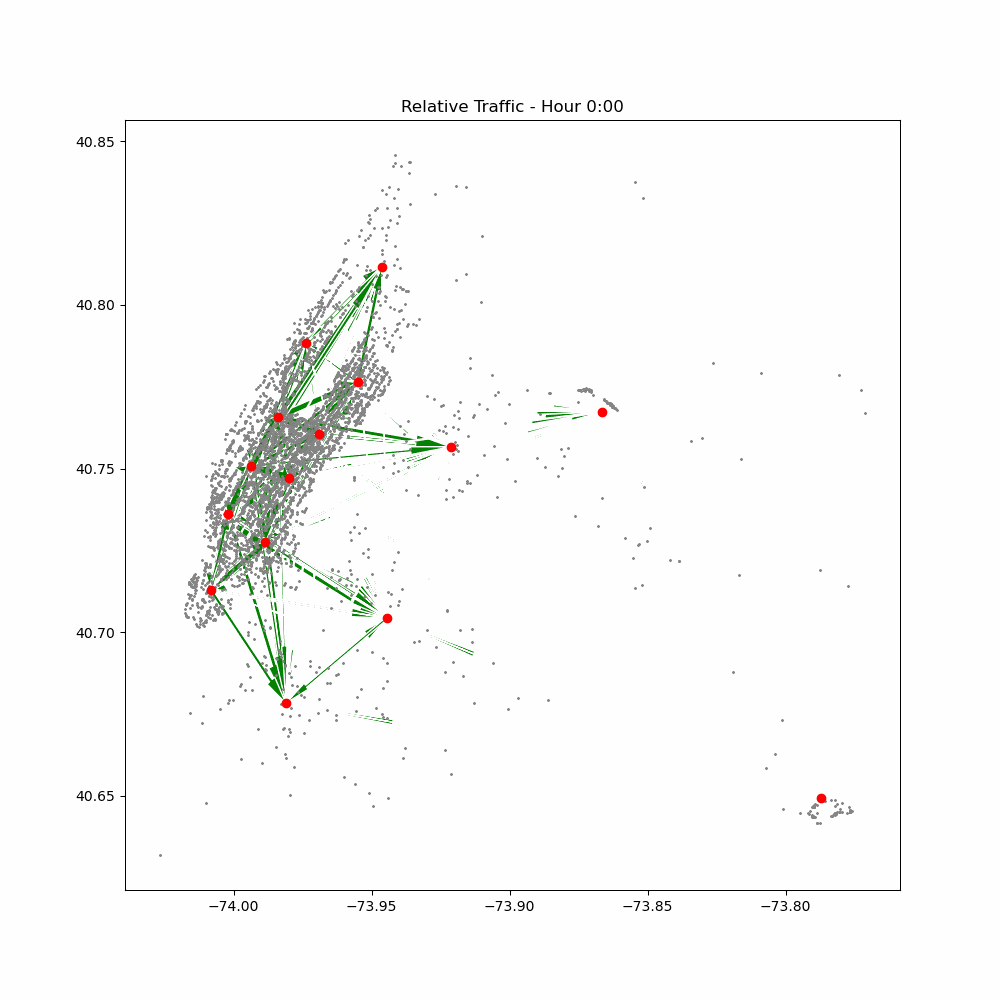

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

아침에는 대부분의 교통량이 Manhattan 섬에 집중되어 있음을 알 수 있습니다.

주로 Williamsburg를 중심으로 Brooklyn 지역으로 이동하는 택시의 점유율은 늦은 저녁에 훨씬 더 커집니다. 아침 시간대(반대 방향)에는 비슷한 움직임이 없기 때문에 출퇴근의 결과일 가능성은 낮습니다.  대신 22시 이후에는 주로 교통량이 많기 때문에 외출하는 사람들일 가능성이 높습니다.

화살표는 해당 시간대의 상대적인 교통량을 나타내므로 Brooklyn으로 향하는 화살표의 폭이 커지는 것은 Manhattan의 상업적 특성으로 인해 Manhattan의 차량 운행이 감소한 결과일 수도 있습니다. 하지만 절대적인 교통량을 보면 Manhattan에서 Brooklyn으로 향하는 화살표는 하루 중 대부분의 시간 동안 거의 보이지 않습니다.

이른 아침에는 대부분의 교통량이 두 공항을 오가는 교통량입니다. absolute graph에서 알 수 있듯이 이는 다른 지역의 트래픽이 감소한 결과일 뿐입니다. 

## Neighborhood Analysis

각 클러스터에 이웃 이름을 수동으로 할당해 보겠습니다.


In [21]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [22]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [24]:
# df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.reshape(-1,1))
# df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.reshape(-1,1))

df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.values.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.values.reshape(-1,1))


# for col in rides_df.columns[:-1]:
#     rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))
    
for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)].values))


c:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\user\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims`

Now let's plot a heatmap and look where do passengers go to and from (These are aggregate values of all rides):

In [26]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [28]:
# trace = go.Heatmap(z= np.array(rides_df.as_matrix()),
#                   x = rides_df.columns[:-1],
#                   y = rides_df.columns)

trace = go.Heatmap(z= np.array(rides_df.values),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)


layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [ ]:
# fig,ax = plt.subplots(figsize = (12,12))
# cax = ax.matshow(rides_df.drop('name',axis = 1),interpolation='nearest',cmap=cm.afmhot)
# cbar = fig.colorbar(cax)
# ax.grid('off')
# ax.set_xticks(range(len(rides_df)))
# ax.set_xticklabels(rides_df.name, rotation =90,fontsize = 15)
# ax.set_yticks(range(len(rides_df)))
# ax.set_yticklabels(rides_df.name,fontsize = 15)
# ax.set_xlabel('To', fontsize = 25)
# ax.set_ylabel('From', fontsize = 25)
# ax.set_title('Neighborhoods Interaction', y=1.35, fontsize = 30)

In [29]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis = 1)

Manhattan 중심부 지역이 가장 택시가 붐비는 지역이며, Upper East side가 선두를 달리고 있음을 알 수 있습니다. 또한 애니메이션에서는 볼 수 없는 클러스터 내에서 가장 많이 승차하는 것을 알 수 있습니다. 

히트맵은 상당히 대칭적이어서 픽업이 하차보다 훨씬 많은 클러스터나 그 반대의 클러스터가 존재하지 않습니다. 확대해 보겠습니다:

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

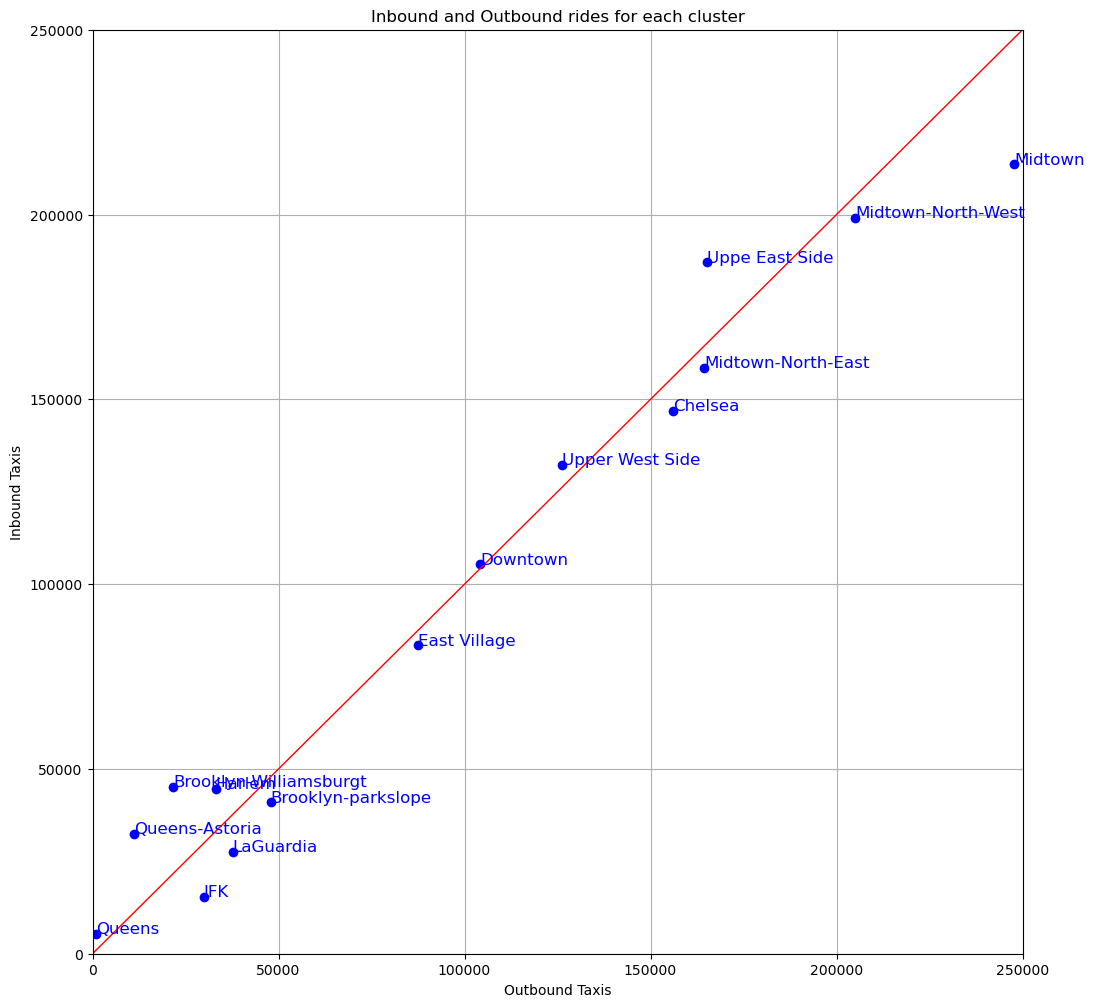

In [30]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

각 지역의 인바운드-아웃바운드 비율이 비교적 균형을 이루고 있음을 알 수 있습니다.

두 공항 모두 인바운드보다 아웃바운드가 더 많은데, 이는 당연한 결과입니다. 승객이 없어도 승객을 시내로 태우기 위해 공항으로 가는 경우가 많기 때문입니다. 주거 지역인 Quuens, Brooklyn, Harlem은 인바운드가 더 많은 반면, 상업 및 관광 지역일수록 아웃바운드가 더 많았습니다. Upper East와 West는 상업 및 주거 지역으로, 거의 곡선을 그리며 나타납니다.

사람들은 다른 교통수단을 이용해 Manhattan에 들어가지만 택시를 타고 나갈 가능성이 더 높은 것으로 보입니다. 

## Winter vs Summer

In [31]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month )

C:\Users\user\AppData\Local\Temp\ipykernel_17364\2359855918.py:11: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\user\AppData\Local\Temp\ipykernel_17364\2359855918.py:12: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



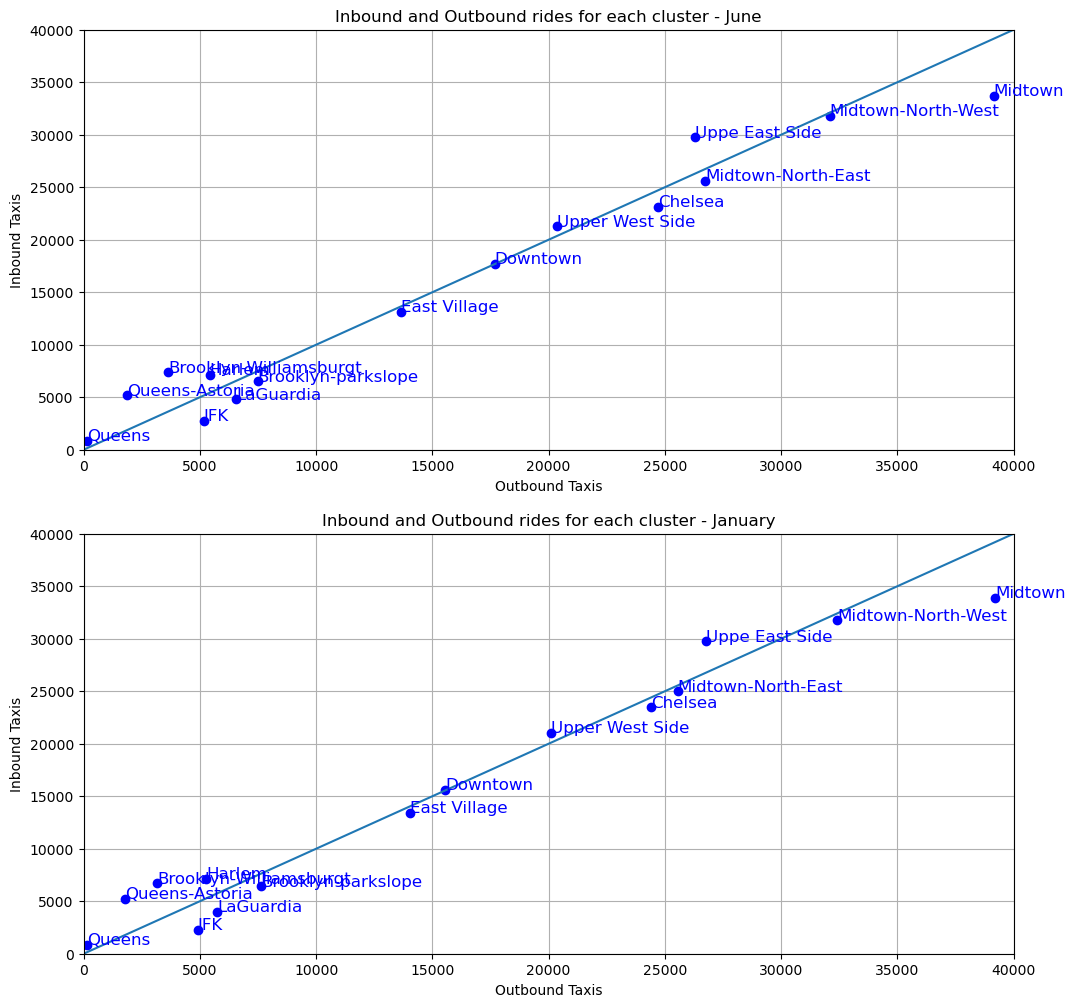

In [32]:
fig,ax = plt.subplots(2,figsize = (12,12))

rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 6)]))
for i in range(len(rides_df)):  
    ax[0].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[0].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0,40000])
ax[0].set_ylim([0,40000])
ax[0].plot([0,40000],[0,40000])


for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) & (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis = 1)
for i in range(len(rides_df)):  
    ax[1].plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax[1].annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0,40000])
ax[1].set_ylim([0,40000])
ax[1].plot([0,40000],[0,40000])

As we can see, the patterns are almost identical regardless of the month. snowy January vs humid and touristic June produce very similar Taxi patterns
보시다시피 패턴은 월에 관계없이 거의 동일합니다. 눈이 내리는 1월과 습하고 관광이 많은 6월의 택시 패턴은 매우 유사합니다.